In [226]:
import warnings
# 경고 메시지를 무시하고 숨기거나
warnings.filterwarnings(action='ignore')

#결과 여러개 뜨게 하기
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [227]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from cvxopt import matrix
from cvxopt.solvers import qp

import arch

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss


## Data Preprocessing for security_selection
Extract only the top 10 cumulative returns over 10 years

In [228]:
#dataframe으로 변환
df_stock_data = pd.read_excel('./dataset.xlsx',index_col=0)
df_stock_data.head()

A005930 A000660   A005490 A005380 A006400 A000270 A012330  \
Symbol                                                                          
Symbol Name            삼성전자  SK하이닉스  POSCO홀딩스     현대차   삼성SDI      기아   현대모비스   
1999-12-28 00:00:00    5320  473074    125000   18000   47200    7100    5750   
2000-01-31 00:00:00    5580  518222    133000   17100   44500    6720    6230   
2000-02-29 00:00:00    5120  351370    111500   12050   32900    4470    4070   
2000-03-31 00:00:00    6700  482889    106500   13400   41000    5000    4070   

                    A035720 A003550 A000810  ... A008800 A010050 A015350  \
Symbol                                       ...                           
Symbol Name             카카오      LG    삼성화재  ...     행남사    우리종금    부산가스   
1999-12-28 00:00:00   34624   42531   34151  ...    4762    1615   15700   
2000-01-31 00:00:00   21769   47389   36792  ...    7470    1157   12700   
2000-02-29 00:00:00   32966   35482   30330  ...    8257    1171   10700   
2000-03-31 00:00:00   18364   37437   27100  ...   14939     942   13000   

                       A023890 A028040  A031390   A033110 A033430 A036260  \
Symbol                                                                      
Symbol Name          한국아트라스비엑스   미래SCI     녹십자셀  코너스톤네트웍스    디에스티  이매진아시아   
1999-12-28 00:00:00       4830   44191  2007335      3690  812543   21328   
2000-01-31 00:00:00       3860   48256  1728974      2800  746062   16506   
2000-02-29 00:00:00       7260   79994  4448870      6750  799986   30015   
2000-03-31 00:00:00       6280   77748  3289657      5800  724197   62767   

                     A036490  
Symbol                        
Symbol Name          SK머티리얼즈  
1999-12-28 00:00:00    18800  
2000-01-31 00:00:00     7050  
2000-02-29 00:00:00    14500  
2000-03-31 00:00:00    10800  

[5 rows x 664 columns]

In [229]:
#전략 
df_train = df_stock_data.iloc[1:122,:]
#월별 수익률(2000~2009)
df_profit = df_train.pct_change()

#상위 누적수익률로 포트폴리오 짜는 방법
df_profit_acc = (1+df_profit).cumprod()-1
select_stocks = df_profit_acc.iloc[-1,:].sort_values(ascending = False)
select_stocks = list(select_stocks[:25].index)

In [230]:
# # 랜덤으로 짜는 방법
# import random
# columns = list(df_profit.columns)
# select_stocks = random.sample(columns, 50)

### 1. 예상 수익률과 종목 변동성을 각각 arima와 garch로 구함
### 2. makowitz 공식에 대입해서 weight값 구함
### 3. weight값을 토대로 월별 수익률을 기록 이후 sliding window 방식으로 백테스팅

In [271]:
def predict_with_arima(stock_rate):
    model = ARIMA(stock_rate.diff(), order=(1,0,1)).fit()
    forcast = model.forecast(steps=1)
    return np.array(forcast)[0] + stock_rate[-1]

In [272]:
def predict_with_garch(stock_rate):
    model = arch.arch_model(stock_rate,vol='GARCH', p=1,q=1).fit()
    forcast = model.forecast(horizon=1)
    return np.sqrt(forcast.variance[-1:].values[0][0])
    

In [273]:
# #저장한걸 불러오기
# stock_list = pd.read_excel('num_is_25_r_min_001_random2.xlsx')
# 
# select_stocks = list(stock_list.columns)
# select_stocks

In [276]:
#포트폴리오 연수익을 구하는 함수
def calculate_return_rate(select_stocks):    
    df_month_profit = df_stock_data.iloc[1:,:][select_stocks].pct_change().dropna()
    num = len(select_stocks)
    return_rate = []
    #walk forward analysis

    index = list(df_month_profit.index)[120:len(df_month_profit)]
    
    #총 데이터 갯수 252개(0~251) 132번 테스트 
    for i in range(0,len(df_month_profit)-120):
        security_selection_train_return = df_month_profit.iloc[i:120+i,:]
        security_selection_test_return = df_month_profit.iloc[120+i,:]
    
        corr = security_selection_train_return.corr().to_numpy()
    
        r_min = 0.01
        mean_list = []
        sigma_list = []
        for j in range(num):
            target = security_selection_train_return.iloc[:,j]
            forcast_return_result = predict_with_arima(target)
            mean_list.append(forcast_return_result)
    
            forcast_vot_result = predict_with_garch(target)
            sigma_list.append(forcast_vot_result)
    
    
        #공분산 행렬 만들기 sigma @ T(sigma) * corr    
        #이부분을 함수로 빼기
        Mean = matrix([mean_list])
        sigma = matrix([sigma_list])
        sigma = sigma@np.transpose(sigma)
        cov = matrix(sigma*corr)
    
        G = matrix(np.concatenate((-np.transpose(Mean), -np.identity(num)), 0))
        h = matrix(np.concatenate((-np.ones((1,1))*r_min, np.zeros((num,1))), 0))
        A = matrix(1.0, (1,num))
        b = matrix(1.0)
        q = matrix(np.zeros((num,1)))
        sol = qp(cov, q, G, h, A ,b)
    
        weight = sol['x']
        weight = np.transpose(weight)
        x = matrix(security_selection_test_return)
        month_return = weight @ x
        return_rate.append(month_return[0][0])
    
    return_rate = pd.DataFrame(return_rate)
    return_rate.index = index
    
    return df_month_profit,return_rate

In [277]:
return_rate = calculate_return_rate(select_stocks)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1296388035.1040711
Iteration:      2,   Func. Count:     13,   Neg. LLF: 808385282.9567895
Iteration:      3,   Func. Count:     20,   Neg. LLF: 3008.0360806639364
Iteration:      4,   Func. Count:     26,   Neg. LLF: 136.98022404052568
Iteration:      5,   Func. Count:     32,   Neg. LLF: 126.04842915067809
Iteration:      6,   Func. Count:     38,   Neg. LLF: 123.8535784976342
Iteration:      7,   Func. Count:     44,   Neg. LLF: 122.80902601403723
Iteration:      8,   Func. Count:     50,   Neg. LLF: 121.36356555534641
Iteration:      9,   Func. Count:     55,   Neg. LLF: 121.24302365289358
Iteration:     10,   Func. Count:     60,   Neg. LLF: 121.18976967861255
Iteration:     11,   Func. Count:     65,   Neg. LLF: 121.18133127306344
Iteration:     12,   Func. Count:     70,   Neg. LLF: 121.17958320805627
Iteration:     13,   Func. Count:     75,   Neg. LLF: 121.17923443750375
Iteration:     14,   Func. Count:     80,   Neg. LLF:

In [278]:
df_month_profit, return_rate = return_rate

In [279]:
# #종목 내보내기
# df_month_profit.to_excel('num_is_25_r_min_001_random.xlsx')

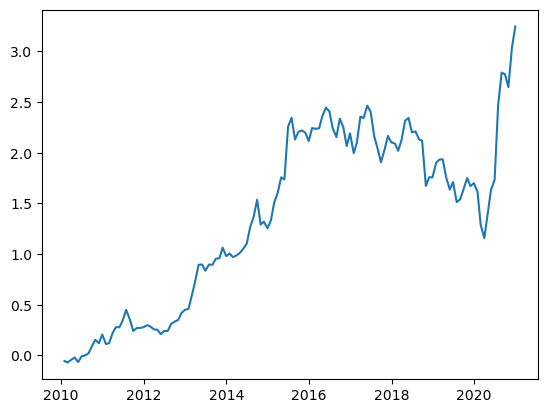

In [314]:
# 누적수익률
df_profit_accumulate = (1+return_rate).cumprod()-1


In [317]:
#코스피 표시

df_kospi_data = pd.read_excel('./kospi.xlsx',index_col=0)
df_kospi_data_pct_return = df_kospi_data.pct_change().dropna()
df_kospi_data_accumulate_return = (1+df_kospi_data_pct_return).cumprod()-1

df_kospi_data_accumulate_return.index = df_profit_accumulate.index
df_kospi_data_accumulate_return
# plt.plot(df_profit_accumulate)
# plt.plot(df_kospi_data_accumulate_return)


지수
2010-01-29 -0.047743
2010-02-26 -0.052408
2010-03-31  0.005990
2010-04-30  0.034936
2010-05-31 -0.024674
...              ...
2020-08-31  0.382346
2020-09-29  0.383368
2020-10-30  0.347273
2020-11-30  0.539925
2020-12-30  0.707583

[132 rows x 1 columns]

In [318]:
df_kospi_data_accumulate_return

지수
2010-01-29 -0.047743
2010-02-26 -0.052408
2010-03-31  0.005990
2010-04-30  0.034936
2010-05-31 -0.024674
...              ...
2020-08-31  0.382346
2020-09-29  0.383368
2020-10-30  0.347273
2020-11-30  0.539925
2020-12-30  0.707583

[132 rows x 1 columns]

In [323]:
def calculate_value(return_rate):
    acc_return_rate = (1+return_rate)
    initial_price = 100
    acc_return_rate.iloc[0,:] = acc_return_rate.iloc[0,:] * initial_price
    acc_return_rate = acc_return_rate.cumprod()
    
    return acc_return_rate
    

In [335]:
def cal_sharpe(return_rate):
    acc_return_rate = calculate_value(return_rate)
    initial_price = 100
    last_price = acc_return_rate.iloc[-1,:][0]
    
    annualized_return = np.power(last_price/initial_price,1/11)-1
    annualized_std = return_rate.std()*np.sqrt(12)
    #샤프지수
    sharp = annualized_return / annualized_std
    print(f'annualized_return : {annualized_return}\nannualized_std : {annualized_std[0]}\nsharp: {sharp[0]}')
    
    

In [336]:
cal_sharpe(return_rate)

annualized_return : 0.14048132288958626
annualized_std : 0.18947976120800522
sharp: 0.7414054250119624


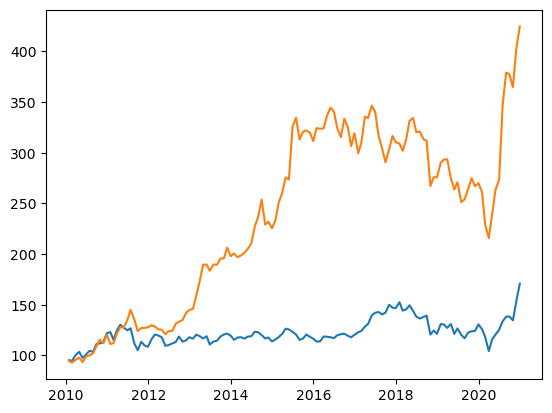

In [337]:
df_kospi_data_pct_return.index = return_rate.index

plt.plot(calculate_value(df_kospi_data_pct_return))
plt.plot(calculate_value(return_rate))


In [338]:
cal_sharpe(df_kospi_data_pct_return)

annualized_return : 0.04984607247076611
annualized_std : 0.14827414561829808
sharp: 0.3361750780145096
